In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

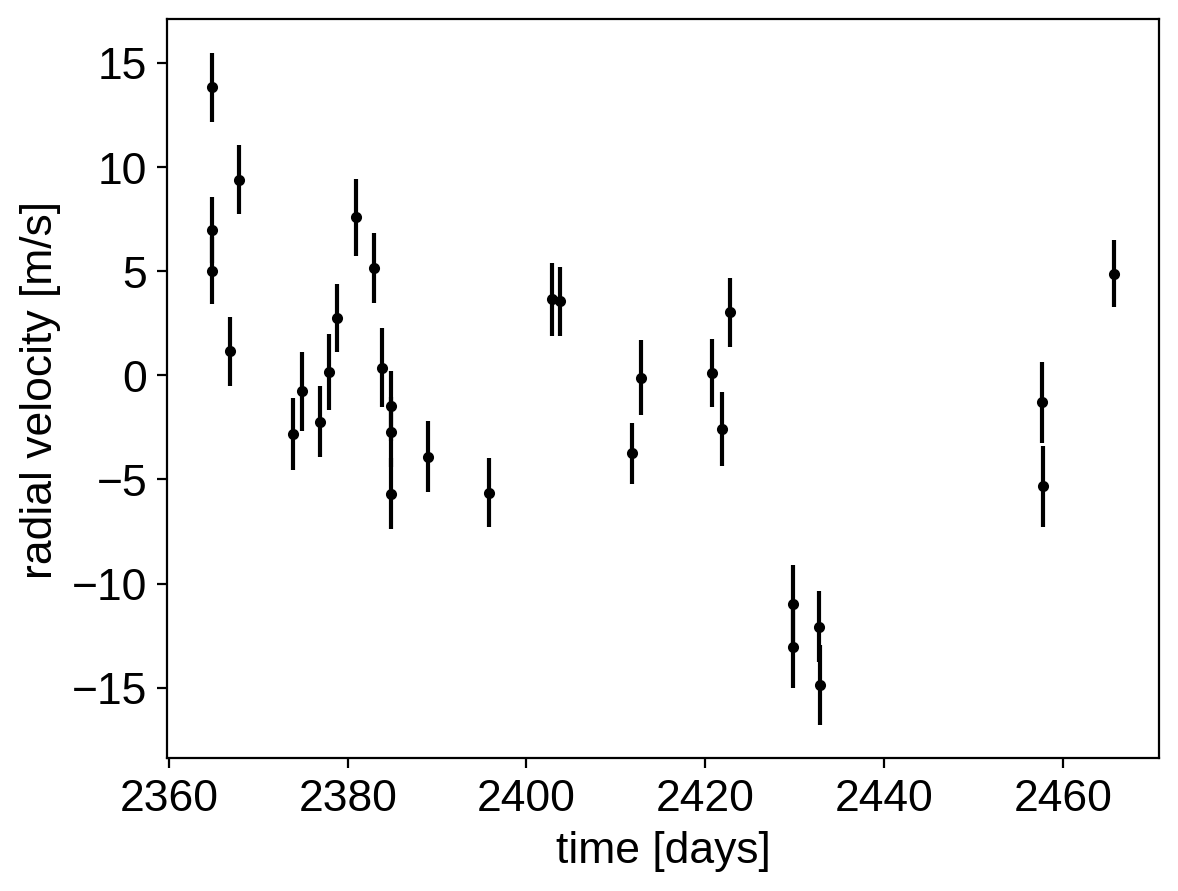

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


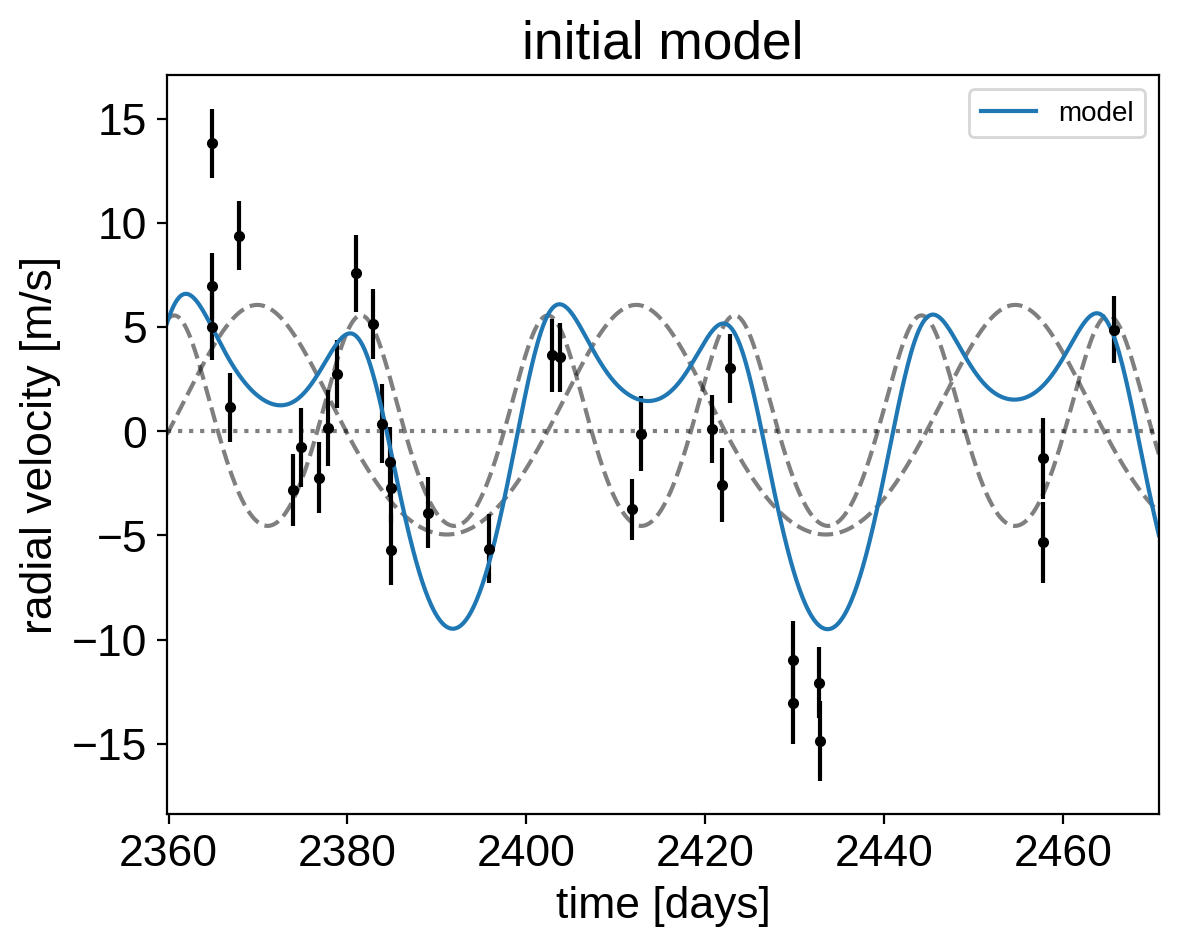

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [7]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 229.32it/s, logp=-7.973266e+01]

2it [00:00, 364.09it/s, logp=-5.305392e+06]

3it [00:00, 468.11it/s, logp=-7.966783e+01]

4it [00:00, 546.85it/s, logp=-7.953812e+01]

5it [00:00, 621.71it/s, logp=-7.904438e+01]

6it [00:00, 684.62it/s, logp=-7.747076e+01]

7it [00:00, 724.42it/s, logp=-7.344108e+01]

8it [00:00, 755.99it/s, logp=-6.722892e+01]

9it [00:00, 764.28it/s, logp=-6.484820e+01]

10it [00:00, 792.05it/s, logp=-6.484820e+01]

11it [00:00, 788.89it/s, logp=-6.484820e+01]

12it [00:03,  3.53it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 219.42it/s, logp=-6.484820e+01]

2it [00:00, 324.39it/s, logp=-4.990134e+09]

3it [00:00, 383.89it/s, logp=-6.484832e+01]

4it [00:00, 448.54it/s, logp=-6.484777e+01]

5it [00:00, 494.27it/s, logp=-6.519268e+01]

6it [00:00, 545.20it/s, logp=-6.484777e+01]

7it [00:00, 580.62it/s, logp=-6.484777e+01]

8it [00:00, 617.62it/s, logp=-6.484776e+01]

9it [00:00, 649.79it/s, logp=-6.484774e+01]

10it [00:00, 679.29it/s, logp=-6.484767e+01]

11it [00:00, 706.40it/s, logp=-6.484739e+01]

12it [00:00, 731.10it/s, logp=-6.484633e+01]

13it [00:00, 738.26it/s, logp=-6.484353e+01]

14it [00:00, 759.57it/s, logp=-6.483426e+01]

15it [00:00, 767.09it/s, logp=-6.481055e+01]

16it [00:00, 784.22it/s, logp=-6.472940e+01]

17it [00:00, 774.45it/s, logp=-6.451928e+01]

18it [00:00, 785.51it/s, logp=-6.371170e+01]

19it [00:00, 799.76it/s, logp=-6.096678e+01]

20it [00:00, 806.97it/s, logp=-5.708652e+01]

21it [00:00, 800.45it/s, logp=-5.027536e+01]

22it [00:00, 802.25it/s, logp=-2.386568e+02]

23it [00:00, 808.62it/s, logp=-4.912172e+01]

24it [00:00, 803.71it/s, logp=-4.707357e+01]

25it [00:00, 805.47it/s, logp=-4.319328e+01]

26it [00:00, 811.10it/s, logp=-3.608487e+01]

27it [00:00, 796.45it/s, logp=-2.498567e+01]

28it [00:00, 801.80it/s, logp=-2.442071e+01]

29it [00:00, 806.85it/s, logp=-2.333036e+01]

30it [00:00, 815.20it/s, logp=-2.011091e+01]

31it [00:00, 811.14it/s, logp=-1.751350e+01]

32it [00:00, 815.76it/s, logp=-1.714559e+01]

33it [00:00, 817.74it/s, logp=-1.693796e+01]

34it [00:00, 813.79it/s, logp=-1.684943e+01]

35it [00:00, 813.80it/s, logp=-1.676095e+01]

36it [00:00, 814.45it/s, logp=-1.673569e+01]

37it [00:00, 815.19it/s, logp=-1.672214e+01]

38it [00:00, 817.90it/s, logp=-1.670758e+01]

39it [00:00, 816.91it/s, logp=-1.668064e+01]

40it [00:00, 820.96it/s, logp=-1.662858e+01]

41it [00:00, 825.76it/s, logp=-1.658058e+01]

42it [00:00, 830.86it/s, logp=-1.655728e+01]

43it [00:00, 828.19it/s, logp=-1.662929e+01]

44it [00:00, 823.68it/s, logp=-1.647872e+01]

45it [00:00, 824.83it/s, logp=-1.635178e+01]

46it [00:00, 824.46it/s, logp=-1.613280e+01]

47it [00:00, 825.23it/s, logp=-1.577352e+01]

48it [00:00, 825.49it/s, logp=-1.525205e+01]

49it [00:00, 826.38it/s, logp=-1.849895e+01]

50it [00:00, 830.98it/s, logp=-1.514689e+01]

51it [00:00, 830.16it/s, logp=-1.501721e+01]

52it [00:00, 832.91it/s, logp=-1.496658e+01]

53it [00:00, 832.00it/s, logp=-1.495457e+01]

54it [00:00, 831.53it/s, logp=-1.494704e+01]

55it [00:00, 832.92it/s, logp=-1.494509e+01]

56it [00:00, 833.06it/s, logp=-1.494181e+01]

57it [00:00, 834.25it/s, logp=-1.493619e+01]

58it [00:00, 832.39it/s, logp=-1.492655e+01]

59it [00:00, 834.47it/s, logp=-1.491151e+01]

60it [00:00, 833.40it/s, logp=-1.489345e+01]

61it [00:00, 834.49it/s, logp=-1.486580e+01]

62it [00:00, 836.05it/s, logp=-1.483881e+01]

63it [00:00, 835.13it/s, logp=-1.479783e+01]

64it [00:00, 835.36it/s, logp=-1.475797e+01]

65it [00:00, 835.27it/s, logp=-1.470224e+01]

66it [00:00, 836.44it/s, logp=-1.466581e+01]

67it [00:00, 838.37it/s, logp=-1.465792e+01]

68it [00:00, 839.63it/s, logp=-1.460984e+01]

69it [00:00, 839.22it/s, logp=-1.453216e+01]

70it [00:00, 838.61it/s, logp=-1.441150e+01]

71it [00:00, 837.51it/s, logp=-1.431230e+01]

72it [00:00, 837.46it/s, logp=-1.436794e+01]

73it [00:00, 841.29it/s, logp=-1.429690e+01]

74it [00:00, 839.57it/s, logp=-1.428194e+01]

75it [00:00, 839.51it/s, logp=-1.427769e+01]

76it [00:00, 840.12it/s, logp=-1.427703e+01]

77it [00:00, 839.65it/s, logp=-1.427688e+01]

78it [00:00, 839.43it/s, logp=-1.427678e+01]

79it [00:00, 837.56it/s, logp=-1.427677e+01]

80it [00:00, 817.80it/s, logp=-1.427676e+01]

81it [00:00, 818.55it/s, logp=-1.427676e+01]

82it [00:00, 818.27it/s, logp=-1.427676e+01]

83it [00:00, 823.73it/s, logp=-1.427676e+01]

83it [00:00, 823.73it/s, logp=-1.427676e+01]

84it [00:00, 823.73it/s, logp=-1.427676e+01]

85it [00:00, 823.73it/s, logp=-1.427676e+01]

86it [00:00, 823.73it/s, logp=-1.427676e+01]

87it [00:00, 823.73it/s, logp=-1.427676e+01]

88it [00:00, 823.73it/s, logp=-1.427676e+01]

89it [00:00, 823.73it/s, logp=-1.427676e+01]

90it [00:00, 823.73it/s, logp=-1.427676e+01]

91it [00:00, 823.73it/s, logp=-1.427676e+01]

92it [00:00, 823.73it/s, logp=-1.427676e+01]

93it [00:00, 207.40it/s, logp=-1.427676e+01]


message: Optimization terminated successfully.
logp: -64.8482026233154 -> -14.276760262380932


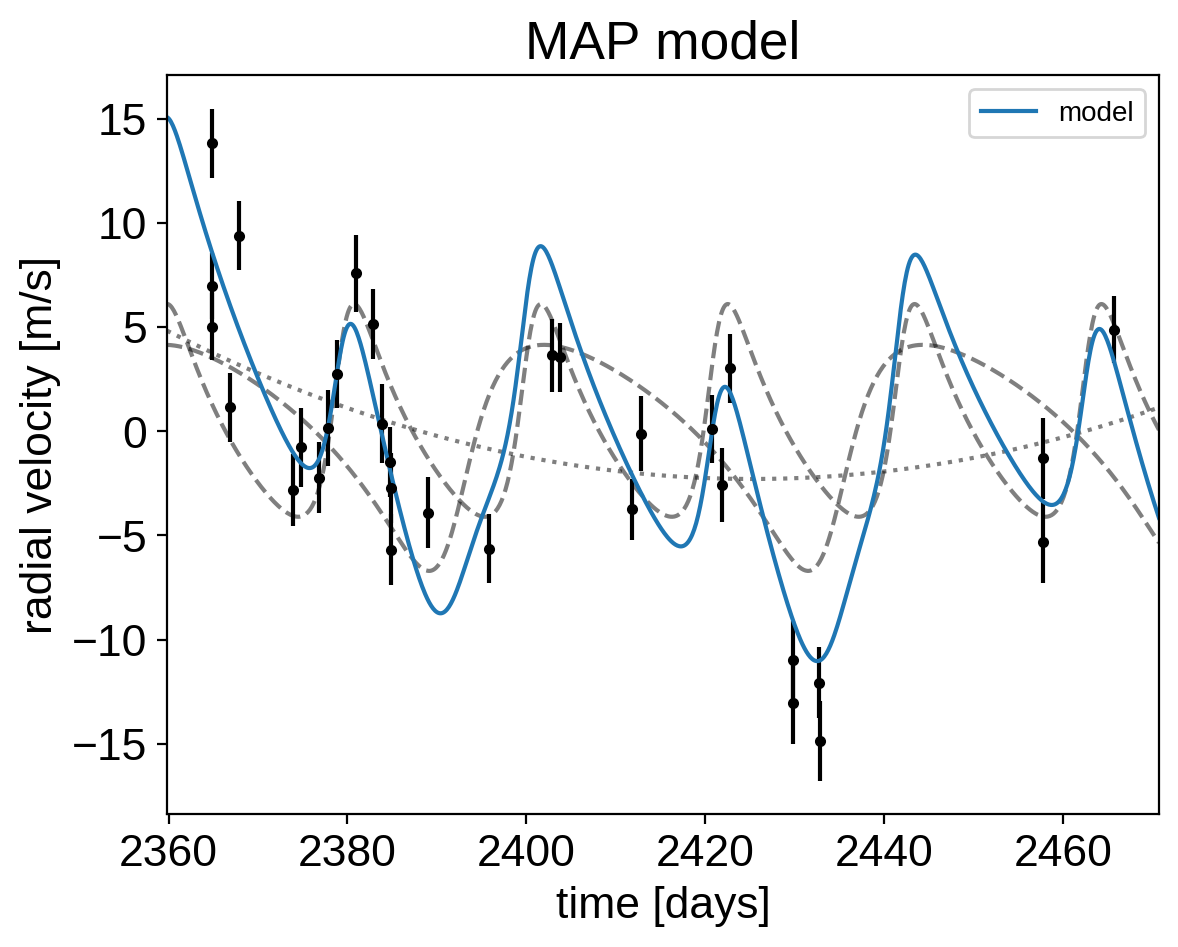

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [9]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/16000 [00:00<03:43, 71.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/16000 [00:00<05:21, 49.67draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/16000 [00:00<06:29, 41.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/16000 [00:00<07:32, 35.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/16000 [00:00<08:01, 33.19draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/16000 [00:00<08:42, 30.56draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/16000 [00:01<09:03, 29.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 39/16000 [00:01<09:19, 28.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 43/16000 [00:01<09:22, 28.36draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 47/16000 [00:01<09:18, 28.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/16000 [00:01<09:15, 28.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/16000 [00:01<09:11, 28.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/16000 [00:01<09:08, 29.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 63/16000 [00:01<09:06, 29.18draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/16000 [00:02<09:23, 28.26draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/16000 [00:02<09:16, 28.64draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 72/16000 [00:02<09:28, 28.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/16000 [00:02<09:21, 28.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 78/16000 [00:02<09:38, 27.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/16000 [00:02<09:52, 26.87draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 86/16000 [00:02<09:43, 27.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/16000 [00:02<09:30, 27.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/16000 [00:03<09:27, 28.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/16000 [00:03<09:17, 28.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/16000 [00:03<09:13, 28.73draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/16000 [00:03<09:15, 28.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/16000 [00:03<09:15, 28.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/16000 [00:03<09:17, 28.49draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/16000 [00:03<09:41, 27.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/16000 [00:04<09:35, 27.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/16000 [00:04<09:31, 27.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/16000 [00:04<09:22, 28.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/16000 [00:04<09:15, 28.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/16000 [00:04<09:17, 28.43draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/16000 [00:04<09:24, 28.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/16000 [00:04<09:23, 28.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/16000 [00:04<09:25, 28.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/16000 [00:05<09:28, 27.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 155/16000 [00:05<09:27, 27.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/16000 [00:05<09:22, 28.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/16000 [00:05<09:28, 27.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 167/16000 [00:05<09:25, 28.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/16000 [00:05<09:23, 28.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/16000 [00:06<09:35, 27.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/16000 [00:06<09:26, 27.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/16000 [00:06<09:15, 28.46draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/16000 [00:06<09:14, 28.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 189/16000 [00:06<09:22, 28.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/16000 [00:06<09:17, 28.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 197/16000 [00:06<09:11, 28.65draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 201/16000 [00:06<09:05, 28.96draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 205/16000 [00:07<09:27, 27.83draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 209/16000 [00:07<09:26, 27.87draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 213/16000 [00:07<09:26, 27.85draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 217/16000 [00:07<09:28, 27.77draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 220/16000 [00:07<10:46, 24.42draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 224/16000 [00:07<10:31, 24.99draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 228/16000 [00:07<10:08, 25.92draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 232/16000 [00:08<10:07, 25.97draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 236/16000 [00:08<09:59, 26.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 240/16000 [00:08<09:41, 27.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/16000 [00:08<09:32, 27.51draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 246/16000 [00:08<09:21, 28.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/16000 [00:08<09:34, 27.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/16000 [00:08<09:29, 27.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/16000 [00:08<09:25, 27.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/16000 [00:09<09:43, 26.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/16000 [00:09<09:35, 27.36draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/16000 [00:09<09:25, 27.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/16000 [00:09<09:18, 28.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/16000 [00:09<09:15, 28.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/16000 [00:09<09:11, 28.50draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/16000 [00:09<09:04, 28.87draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/16000 [00:10<09:25, 27.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/16000 [00:10<09:21, 27.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/16000 [00:10<09:12, 28.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 301/16000 [00:10<09:14, 28.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/16000 [00:10<09:13, 28.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/16000 [00:10<09:25, 27.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 313/16000 [00:10<09:35, 27.27draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 317/16000 [00:11<09:27, 27.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 321/16000 [00:11<09:18, 28.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 325/16000 [00:11<09:13, 28.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 328/16000 [00:11<09:06, 28.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 331/16000 [00:11<09:04, 28.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 334/16000 [00:11<09:14, 28.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 338/16000 [00:11<09:14, 28.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 342/16000 [00:12<09:13, 28.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 346/16000 [00:12<08:55, 29.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 350/16000 [00:12<09:02, 28.84draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 353/16000 [00:12<09:04, 28.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 356/16000 [00:12<09:01, 28.87draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 359/16000 [00:12<09:16, 28.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 363/16000 [00:12<09:28, 27.48draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 367/16000 [00:12<09:22, 27.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/16000 [00:13<09:13, 28.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/16000 [00:13<09:35, 27.13draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/16000 [00:13<10:00, 26.01draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 381/16000 [00:13<08:58, 29.01draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 386/16000 [00:13<08:51, 29.39draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 391/16000 [00:13<08:32, 30.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 395/16000 [00:13<08:19, 31.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 400/16000 [00:13<07:23, 35.18draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 404/16000 [00:14<08:14, 31.52draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 408/16000 [00:14<08:23, 30.99draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 414/16000 [00:14<07:19, 35.48draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 418/16000 [00:14<11:49, 21.96draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 424/16000 [00:14<09:45, 26.60draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 432/16000 [00:14<07:50, 33.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 438/16000 [00:14<06:56, 37.33draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 448/16000 [00:15<05:46, 44.84draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 462/16000 [00:15<04:37, 56.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 471/16000 [00:15<04:33, 56.70draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 480/16000 [00:15<04:20, 59.49draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 488/16000 [00:15<04:03, 63.83draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 498/16000 [00:15<03:41, 70.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 507/16000 [00:15<03:27, 74.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 520/16000 [00:15<03:04, 83.88draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 535/16000 [00:16<02:43, 94.81draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 553/16000 [00:16<02:20, 110.12draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 569/16000 [00:16<02:07, 121.03draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 587/16000 [00:16<01:56, 132.18draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 605/16000 [00:16<01:47, 142.75draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 622/16000 [00:16<01:43, 148.90draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 640/16000 [00:16<01:40, 152.90draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 656/16000 [00:16<01:40, 153.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 672/16000 [00:16<01:43, 147.85draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 688/16000 [00:16<01:41, 150.91draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 704/16000 [00:17<01:39, 153.40draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 720/16000 [00:17<01:42, 149.18draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 738/16000 [00:17<01:37, 155.74draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 757/16000 [00:17<01:33, 162.99draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 774/16000 [00:17<01:33, 162.19draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 794/16000 [00:17<01:29, 170.39draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 814/16000 [00:17<01:27, 173.49draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 832/16000 [00:17<01:27, 172.48draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 850/16000 [00:17<01:29, 168.53draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 867/16000 [00:18<01:33, 161.83draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 884/16000 [00:18<01:38, 153.91draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 900/16000 [00:18<01:49, 137.97draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 915/16000 [00:18<01:49, 137.99draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 932/16000 [00:18<01:44, 144.74draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 949/16000 [00:18<01:40, 149.53draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 967/16000 [00:18<01:36, 155.54draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 987/16000 [00:18<01:30, 166.48draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1008/16000 [00:18<01:24, 176.50draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1027/16000 [00:19<01:24, 176.57draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1045/16000 [00:19<01:25, 175.75draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1063/16000 [00:19<01:31, 164.01draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1080/16000 [00:19<01:31, 162.54draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1100/16000 [00:19<01:27, 170.04draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1118/16000 [00:19<01:26, 172.85draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1140/16000 [00:19<01:21, 182.62draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1162/16000 [00:19<01:17, 191.42draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1186/16000 [00:19<01:12, 203.30draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1207/16000 [00:20<01:12, 203.51draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1228/16000 [00:20<01:18, 187.49draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1248/16000 [00:20<01:23, 176.49draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1267/16000 [00:20<01:29, 164.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1284/16000 [00:20<01:31, 160.90draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1301/16000 [00:20<01:35, 153.25draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1318/16000 [00:20<01:33, 156.31draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1337/16000 [00:20<01:29, 163.46draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1354/16000 [00:20<01:31, 159.41draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1371/16000 [00:21<01:42, 143.09draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1386/16000 [00:21<02:02, 118.86draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1399/16000 [00:21<02:09, 112.32draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1412/16000 [00:21<02:09, 112.58draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1426/16000 [00:21<02:01, 119.54draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1440/16000 [00:21<01:56, 124.84draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1453/16000 [00:21<02:00, 120.51draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1466/16000 [00:21<02:04, 117.20draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1479/16000 [00:22<02:00, 120.36draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1492/16000 [00:22<02:20, 103.19draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1503/16000 [00:22<02:32, 94.86draws/s] 

Sampling 2 chains, 0 divergences:   9%|▉         | 1514/16000 [00:22<02:31, 95.73draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1526/16000 [00:22<02:24, 100.05draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1538/16000 [00:22<02:18, 104.40draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1551/16000 [00:22<02:11, 110.00draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1563/16000 [00:22<02:08, 112.53draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1578/16000 [00:23<02:00, 119.85draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1593/16000 [00:23<01:52, 127.52draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1607/16000 [00:23<02:05, 114.56draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1619/16000 [00:23<02:08, 111.72draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1631/16000 [00:23<02:07, 113.11draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1646/16000 [00:23<01:58, 121.09draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1661/16000 [00:23<01:52, 127.63draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1680/16000 [00:23<01:41, 141.06draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1701/16000 [00:23<01:32, 155.30draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1722/16000 [00:23<01:25, 166.12draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1742/16000 [00:24<01:21, 174.88draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1761/16000 [00:24<01:20, 175.86draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1782/16000 [00:24<01:17, 184.59draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1803/16000 [00:24<01:14, 190.63draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1823/16000 [00:24<01:21, 173.25draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1841/16000 [00:24<01:27, 161.85draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1858/16000 [00:24<01:27, 162.45draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1875/16000 [00:24<01:28, 160.37draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1893/16000 [00:24<01:25, 164.20draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1910/16000 [00:25<01:24, 165.88draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1930/16000 [00:25<01:21, 173.15draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1950/16000 [00:25<01:18, 179.25draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1969/16000 [00:25<01:18, 179.27draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1989/16000 [00:25<01:15, 184.49draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2011/16000 [00:25<01:13, 191.16draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2031/16000 [00:25<01:12, 192.54draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2051/16000 [00:25<01:12, 192.55draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2071/16000 [00:25<01:13, 190.29draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2091/16000 [00:26<01:20, 172.99draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2109/16000 [00:26<01:25, 161.60draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2126/16000 [00:26<01:32, 150.07draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2142/16000 [00:26<01:40, 138.46draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2157/16000 [00:26<01:38, 141.10draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2175/16000 [00:26<01:32, 149.88draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2194/16000 [00:26<01:26, 159.23draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2214/16000 [00:26<01:22, 166.26draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2232/16000 [00:26<01:25, 160.59draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2249/16000 [00:27<01:29, 152.86draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2265/16000 [00:27<01:30, 152.61draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2281/16000 [00:27<01:33, 146.01draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2298/16000 [00:27<01:31, 149.40draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2317/16000 [00:27<01:26, 157.82draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2337/16000 [00:27<01:22, 166.56draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2354/16000 [00:27<01:23, 164.38draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2371/16000 [00:27<01:24, 161.75draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2390/16000 [00:27<01:21, 167.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2409/16000 [00:28<01:19, 170.63draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2430/16000 [00:28<01:16, 177.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2449/16000 [00:28<01:16, 176.90draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2467/16000 [00:28<01:16, 177.26draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2486/16000 [00:28<01:15, 180.01draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2509/16000 [00:28<01:10, 192.33draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2529/16000 [00:28<01:10, 191.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2549/16000 [00:28<01:15, 177.11draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2568/16000 [00:28<01:16, 176.33draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2589/16000 [00:29<01:13, 183.70draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2608/16000 [00:29<01:14, 180.13draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2627/16000 [00:29<01:17, 171.79draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2645/16000 [00:29<01:19, 168.33draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2663/16000 [00:29<01:19, 167.25draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2680/16000 [00:29<01:23, 159.96draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2697/16000 [00:29<01:24, 156.64draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2715/16000 [00:29<01:22, 160.10draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2732/16000 [00:29<01:25, 154.57draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2748/16000 [00:30<01:25, 154.22draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2764/16000 [00:30<01:28, 148.96draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2779/16000 [00:30<01:31, 144.58draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2795/16000 [00:30<01:28, 148.63draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2810/16000 [00:30<01:29, 147.88draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2826/16000 [00:30<01:28, 148.19draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2841/16000 [00:30<01:38, 134.24draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2856/16000 [00:30<01:35, 138.24draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2875/16000 [00:30<01:29, 147.25draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2892/16000 [00:31<01:25, 152.47draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2912/16000 [00:31<01:19, 163.65draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2932/16000 [00:31<01:16, 170.30draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2955/16000 [00:31<01:11, 181.91draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2975/16000 [00:31<01:10, 185.19draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2994/16000 [00:31<01:10, 185.44draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3015/16000 [00:31<01:08, 189.18draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3035/16000 [00:31<01:08, 189.99draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3055/16000 [00:31<01:07, 192.71draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3075/16000 [00:31<01:07, 192.17draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3095/16000 [00:32<01:08, 187.44draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3115/16000 [00:32<01:09, 186.26draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3134/16000 [00:32<01:08, 186.97draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3153/16000 [00:32<01:08, 186.46draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3174/16000 [00:32<01:06, 192.67draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3194/16000 [00:32<01:09, 185.25draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3213/16000 [00:32<01:15, 169.06draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3231/16000 [00:32<01:24, 151.49draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3247/16000 [00:33<01:31, 139.90draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3264/16000 [00:33<01:27, 145.61draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3283/16000 [00:33<01:21, 156.35draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3303/16000 [00:33<01:16, 166.28draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3323/16000 [00:33<01:12, 173.90draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3341/16000 [00:33<01:12, 174.12draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3360/16000 [00:33<01:12, 175.21draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3380/16000 [00:33<01:10, 178.15draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3399/16000 [00:33<01:09, 180.02draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3418/16000 [00:33<01:10, 178.23draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3436/16000 [00:34<01:10, 178.73draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3454/16000 [00:34<01:10, 177.70draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3474/16000 [00:34<01:09, 179.74draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3493/16000 [00:34<01:12, 173.24draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3511/16000 [00:34<01:14, 167.64draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3528/16000 [00:34<01:17, 160.38draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3545/16000 [00:34<01:16, 162.07draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3563/16000 [00:34<01:15, 164.76draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3580/16000 [00:34<01:17, 160.54draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3597/16000 [00:35<01:20, 153.47draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3614/16000 [00:35<01:20, 153.67draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3630/16000 [00:35<01:26, 142.21draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3645/16000 [00:35<01:28, 139.21draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3661/16000 [00:35<01:25, 144.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3678/16000 [00:35<01:22, 149.27draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3698/16000 [00:35<01:16, 161.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3716/16000 [00:35<01:14, 165.24draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3735/16000 [00:35<01:12, 169.11draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3753/16000 [00:36<01:11, 170.31draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3771/16000 [00:36<01:20, 152.78draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3787/16000 [00:36<01:19, 152.75draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3804/16000 [00:36<01:17, 156.49draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3822/16000 [00:36<01:16, 159.90draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3842/16000 [00:36<01:11, 168.87draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3863/16000 [00:36<01:08, 178.30draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3883/16000 [00:36<01:05, 183.94draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3902/16000 [00:36<01:05, 185.60draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3921/16000 [00:37<01:08, 177.52draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3939/16000 [00:37<01:09, 172.51draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3961/16000 [00:37<01:06, 181.15draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3981/16000 [00:37<01:04, 185.31draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4000/16000 [00:37<01:07, 178.55draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4019/16000 [00:37<01:09, 173.49draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4037/16000 [00:37<01:27, 137.45draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4053/16000 [00:37<01:30, 131.74draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4068/16000 [00:38<01:32, 129.08draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4082/16000 [00:38<01:37, 122.04draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4095/16000 [00:38<01:38, 120.58draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4110/16000 [00:38<01:33, 127.69draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4125/16000 [00:38<01:30, 131.61draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4140/16000 [00:38<01:27, 135.98draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4154/16000 [00:38<01:26, 136.70draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4169/16000 [00:38<01:25, 138.16draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4186/16000 [00:38<01:21, 145.13draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4204/16000 [00:39<01:19, 148.86draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4220/16000 [00:39<01:26, 135.49draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4237/16000 [00:39<01:23, 141.35draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4255/16000 [00:39<01:18, 150.49draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4273/16000 [00:39<01:14, 157.35draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4293/16000 [00:39<01:10, 166.92draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4313/16000 [00:39<01:07, 172.33draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4333/16000 [00:39<01:05, 179.07draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4352/16000 [00:39<01:04, 179.30draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4373/16000 [00:40<01:02, 184.61draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4393/16000 [00:40<01:01, 188.62draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4413/16000 [00:40<01:01, 187.34draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4432/16000 [00:40<01:02, 186.29draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4451/16000 [00:40<01:03, 180.93draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4472/16000 [00:40<01:03, 181.26draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4492/16000 [00:40<01:01, 185.94draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4511/16000 [00:40<01:01, 186.13draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4530/16000 [00:40<01:05, 176.12draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4548/16000 [00:40<01:08, 167.86draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4565/16000 [00:41<01:08, 166.58draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4583/16000 [00:41<01:08, 167.00draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4600/16000 [00:41<01:10, 161.04draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4617/16000 [00:41<01:14, 153.45draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4634/16000 [00:41<01:12, 157.52draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4653/16000 [00:41<01:08, 165.70draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4670/16000 [00:41<01:08, 165.02draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4687/16000 [00:41<01:09, 162.41draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4704/16000 [00:41<01:13, 153.22draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4720/16000 [00:42<01:20, 139.71draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4735/16000 [00:42<01:22, 137.23draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4749/16000 [00:42<01:23, 135.35draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4763/16000 [00:42<01:26, 129.85draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4777/16000 [00:42<01:25, 132.02draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4792/16000 [00:42<01:22, 136.68draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4808/16000 [00:42<01:18, 142.90draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4824/16000 [00:42<01:17, 143.84draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4841/16000 [00:42<01:14, 149.77draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4857/16000 [00:43<01:13, 152.52draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4874/16000 [00:43<01:12, 154.21draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4892/16000 [00:43<01:10, 158.49draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4912/16000 [00:43<01:06, 167.66draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4932/16000 [00:43<01:03, 174.36draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4951/16000 [00:43<01:01, 178.37draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4970/16000 [00:43<01:01, 179.92draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4989/16000 [00:43<01:02, 176.88draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5007/16000 [00:43<01:02, 175.76draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5025/16000 [00:44<01:02, 175.71draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5043/16000 [00:44<01:03, 172.79draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5063/16000 [00:44<01:01, 178.09draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5083/16000 [00:44<00:59, 184.05draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5104/16000 [00:44<00:57, 188.98draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5124/16000 [00:44<00:57, 188.08draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5144/16000 [00:44<00:56, 191.14draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5164/16000 [00:44<00:56, 193.29draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5184/16000 [00:44<00:56, 192.33draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5204/16000 [00:44<00:55, 192.80draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5224/16000 [00:45<00:58, 185.07draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5244/16000 [00:45<00:57, 187.47draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5263/16000 [00:45<00:57, 186.96draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5282/16000 [00:45<00:57, 186.65draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5301/16000 [00:45<00:57, 186.07draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5320/16000 [00:45<00:58, 181.85draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5339/16000 [00:45<00:58, 181.41draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5358/16000 [00:45<01:02, 170.66draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5377/16000 [00:45<01:00, 175.56draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5397/16000 [00:46<00:59, 177.84draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5416/16000 [00:46<00:58, 179.82draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5435/16000 [00:46<00:58, 179.48draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5455/16000 [00:46<00:57, 183.50draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5476/16000 [00:46<00:56, 186.88draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5498/16000 [00:46<00:53, 195.39draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5520/16000 [00:46<00:52, 198.23draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5543/16000 [00:46<00:51, 204.63draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5564/16000 [00:46<00:55, 186.49draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5584/16000 [00:47<00:57, 182.17draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5603/16000 [00:47<00:57, 180.95draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5622/16000 [00:47<00:58, 177.08draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5640/16000 [00:47<01:01, 168.97draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5658/16000 [00:47<01:02, 166.26draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5675/16000 [00:47<01:02, 166.45draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5693/16000 [00:47<01:00, 168.98draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5711/16000 [00:47<01:01, 168.46draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5728/16000 [00:47<01:03, 161.74draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5745/16000 [00:47<01:02, 164.08draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5762/16000 [00:48<01:01, 165.31draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5783/16000 [00:48<00:58, 173.79draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5803/16000 [00:48<00:56, 180.68draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5822/16000 [00:48<00:55, 182.28draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5841/16000 [00:48<00:55, 183.14draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5860/16000 [00:48<00:56, 178.35draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5881/16000 [00:48<00:54, 184.80draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5900/16000 [00:48<00:55, 181.43draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5919/16000 [00:48<00:56, 178.30draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5937/16000 [00:49<00:57, 175.81draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5955/16000 [00:49<00:57, 175.05draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5975/16000 [00:49<00:55, 181.50draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5994/16000 [00:49<00:55, 181.37draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6013/16000 [00:49<00:55, 180.88draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6034/16000 [00:49<00:53, 187.99draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6056/16000 [00:49<00:50, 195.11draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6077/16000 [00:49<00:50, 198.37draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6097/16000 [00:49<00:49, 198.76draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6118/16000 [00:49<00:49, 198.48draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6138/16000 [00:50<00:52, 186.43draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6157/16000 [00:50<00:53, 182.50draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6176/16000 [00:50<00:54, 181.88draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6195/16000 [00:50<00:54, 180.36draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6214/16000 [00:50<00:56, 173.77draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6232/16000 [00:50<00:59, 164.29draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6249/16000 [00:50<01:02, 155.46draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6265/16000 [00:50<01:06, 147.18draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6281/16000 [00:51<01:05, 148.33draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6297/16000 [00:51<01:08, 142.66draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6312/16000 [00:51<01:07, 144.27draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6329/16000 [00:51<01:05, 147.73draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6344/16000 [00:51<01:05, 147.02draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6364/16000 [00:51<01:01, 156.56draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6382/16000 [00:51<00:59, 161.93draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6400/16000 [00:51<00:58, 164.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6419/16000 [00:51<00:55, 171.34draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6439/16000 [00:51<00:53, 177.61draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6457/16000 [00:52<00:57, 165.14draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6474/16000 [00:52<01:01, 156.08draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6490/16000 [00:52<01:12, 130.82draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6504/16000 [00:52<01:21, 116.05draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6517/16000 [00:52<01:22, 115.52draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6530/16000 [00:52<01:24, 112.17draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6542/16000 [00:52<01:24, 111.28draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6554/16000 [00:52<01:26, 108.62draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6566/16000 [00:53<01:29, 105.34draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6578/16000 [00:53<01:28, 107.00draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6591/16000 [00:53<01:23, 112.84draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6606/16000 [00:53<01:17, 120.95draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6623/16000 [00:53<01:10, 132.27draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6642/16000 [00:53<01:04, 145.13draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6660/16000 [00:53<01:01, 151.91draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6676/16000 [00:53<01:01, 151.02draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6692/16000 [00:53<01:08, 135.34draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6709/16000 [00:54<01:05, 141.08draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6727/16000 [00:54<01:01, 150.73draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6745/16000 [00:54<00:59, 156.33draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6763/16000 [00:54<00:57, 160.60draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6781/16000 [00:54<00:55, 165.51draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6801/16000 [00:54<00:52, 174.08draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6819/16000 [00:54<00:55, 166.08draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6836/16000 [00:54<00:57, 158.92draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6853/16000 [00:54<00:56, 161.98draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6870/16000 [00:55<00:56, 160.93draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6887/16000 [00:55<01:01, 147.08draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6903/16000 [00:55<01:02, 144.66draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6918/16000 [00:55<01:05, 137.87draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6933/16000 [00:55<01:05, 139.48draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6948/16000 [00:55<01:05, 138.01draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6962/16000 [00:55<01:06, 135.77draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6978/16000 [00:55<01:04, 139.56draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6994/16000 [00:55<01:02, 143.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7009/16000 [00:56<01:02, 144.34draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7024/16000 [00:56<01:01, 144.94draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7039/16000 [00:56<01:02, 143.65draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7054/16000 [00:56<01:01, 144.33draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7069/16000 [00:56<01:01, 144.25draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7085/16000 [00:56<00:59, 148.61draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7103/16000 [00:56<00:57, 155.30draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7122/16000 [00:56<00:55, 161.05draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7139/16000 [00:56<00:54, 163.40draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7156/16000 [00:57<00:54, 161.60draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7174/16000 [00:57<00:53, 165.07draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7193/16000 [00:57<00:51, 170.02draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7211/16000 [00:57<00:54, 160.54draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7228/16000 [00:57<00:55, 157.83draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7245/16000 [00:57<00:55, 158.96draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7262/16000 [00:57<00:54, 161.32draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7280/16000 [00:57<00:52, 165.63draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7299/16000 [00:57<00:50, 171.50draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7319/16000 [00:57<00:49, 176.47draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7339/16000 [00:58<00:47, 182.40draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7359/16000 [00:58<00:46, 187.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7379/16000 [00:58<00:45, 190.19draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7399/16000 [00:58<00:45, 189.51draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7419/16000 [00:58<00:46, 185.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7438/16000 [00:58<00:49, 173.02draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7456/16000 [00:58<00:52, 162.37draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7473/16000 [00:58<00:53, 158.10draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7492/16000 [00:58<00:52, 163.18draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7509/16000 [00:59<00:52, 161.74draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7526/16000 [00:59<00:51, 163.31draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7543/16000 [00:59<00:51, 163.19draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7561/16000 [00:59<00:51, 165.03draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7580/16000 [00:59<00:49, 171.34draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7600/16000 [00:59<00:47, 178.15draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7620/16000 [00:59<00:45, 183.16draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7639/16000 [00:59<00:47, 176.38draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7657/16000 [00:59<00:51, 162.33draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7674/16000 [01:00<00:53, 156.97draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7690/16000 [01:00<00:54, 152.82draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7706/16000 [01:00<00:53, 154.81draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7723/16000 [01:00<00:52, 156.47draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7739/16000 [01:00<00:54, 150.34draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7755/16000 [01:00<00:54, 152.22draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7772/16000 [01:00<00:52, 156.85draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7788/16000 [01:00<00:54, 149.89draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7804/16000 [01:00<00:57, 142.59draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7819/16000 [01:01<00:58, 139.96draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7834/16000 [01:01<00:58, 139.54draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7849/16000 [01:01<00:58, 139.07draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7865/16000 [01:01<00:57, 141.33draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7881/16000 [01:01<00:56, 144.50draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7898/16000 [01:01<00:54, 147.91draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7915/16000 [01:01<00:52, 152.69draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7931/16000 [01:01<00:53, 151.87draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7947/16000 [01:01<00:52, 153.55draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7963/16000 [01:01<00:52, 154.02draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7979/16000 [01:02<00:52, 153.57draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7998/16000 [01:02<00:49, 162.69draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8015/16000 [01:02<00:49, 161.46draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8032/16000 [01:02<00:52, 152.96draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8051/16000 [01:02<00:49, 160.90draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8070/16000 [01:02<00:47, 167.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8091/16000 [01:02<00:44, 176.77draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8111/16000 [01:02<00:43, 180.10draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8131/16000 [01:02<00:42, 184.12draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8150/16000 [01:03<00:42, 183.00draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8170/16000 [01:03<00:42, 184.39draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8190/16000 [01:03<00:41, 188.59draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8211/16000 [01:03<00:40, 192.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8231/16000 [01:03<00:41, 189.03draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8250/16000 [01:03<00:41, 185.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8269/16000 [01:03<00:43, 178.49draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8287/16000 [01:03<00:46, 167.46draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8304/16000 [01:03<00:48, 157.13draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8320/16000 [01:04<00:50, 152.27draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8336/16000 [01:04<00:51, 149.30draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8352/16000 [01:04<00:53, 144.18draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8368/16000 [01:04<00:51, 148.01draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8383/16000 [01:04<00:52, 145.81draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8399/16000 [01:04<00:51, 146.81draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8414/16000 [01:04<00:51, 146.10draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8429/16000 [01:04<00:51, 146.62draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8446/16000 [01:04<00:49, 151.95draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8464/16000 [01:05<00:48, 156.96draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8480/16000 [01:05<00:48, 156.30draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8496/16000 [01:05<00:48, 155.03draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8512/16000 [01:05<00:49, 151.91draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8528/16000 [01:05<00:52, 142.89draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8545/16000 [01:05<00:51, 145.66draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8560/16000 [01:05<00:52, 140.64draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8576/16000 [01:05<00:52, 142.09draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8596/16000 [01:05<00:48, 152.50draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8612/16000 [01:06<00:49, 148.66draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8628/16000 [01:06<00:48, 151.14draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8648/16000 [01:06<00:45, 160.52draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8667/16000 [01:06<00:44, 165.57draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8686/16000 [01:06<00:43, 168.93draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8706/16000 [01:06<00:41, 174.35draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8725/16000 [01:06<00:40, 177.52draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8745/16000 [01:06<00:39, 182.77draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8764/16000 [01:06<00:39, 182.66draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8783/16000 [01:06<00:39, 181.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8802/16000 [01:07<00:41, 174.46draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8820/16000 [01:07<00:41, 173.99draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8839/16000 [01:07<00:40, 174.80draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8857/16000 [01:07<00:40, 175.84draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8876/16000 [01:07<00:40, 177.06draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8894/16000 [01:07<00:40, 173.58draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8913/16000 [01:07<00:40, 176.95draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8931/16000 [01:07<00:40, 175.62draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8949/16000 [01:07<00:40, 173.66draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8967/16000 [01:08<00:41, 171.28draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8985/16000 [01:08<00:42, 165.83draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9004/16000 [01:08<00:41, 168.66draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9022/16000 [01:08<00:41, 169.59draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9039/16000 [01:08<00:42, 164.13draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9056/16000 [01:08<00:43, 159.55draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9073/16000 [01:08<00:43, 158.67draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9091/16000 [01:08<00:42, 163.87draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9109/16000 [01:08<00:41, 167.42draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9128/16000 [01:09<00:39, 172.95draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9146/16000 [01:09<00:40, 168.97draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9163/16000 [01:09<00:41, 165.80draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9183/16000 [01:09<00:39, 171.40draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9202/16000 [01:09<00:39, 172.60draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9220/16000 [01:09<00:39, 170.26draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9238/16000 [01:09<00:39, 172.95draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9257/16000 [01:09<00:39, 171.05draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9276/16000 [01:09<00:38, 175.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9296/16000 [01:09<00:37, 178.46draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9314/16000 [01:10<00:38, 174.79draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9332/16000 [01:10<00:38, 171.59draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9350/16000 [01:10<00:39, 169.71draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9368/16000 [01:10<00:39, 169.06draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9388/16000 [01:10<00:37, 174.40draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9407/16000 [01:10<00:37, 178.16draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9425/16000 [01:10<00:37, 173.27draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9444/16000 [01:10<00:37, 175.63draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9463/16000 [01:10<00:37, 176.60draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9481/16000 [01:11<00:38, 170.92draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9499/16000 [01:11<00:38, 170.29draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9517/16000 [01:11<00:39, 166.00draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9536/16000 [01:11<00:38, 168.67draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9553/16000 [01:11<00:38, 166.70draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9570/16000 [01:11<00:39, 161.93draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9589/16000 [01:11<00:38, 167.02draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9606/16000 [01:11<00:38, 164.78draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9625/16000 [01:11<00:37, 169.52draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9645/16000 [01:12<00:36, 174.36draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9663/16000 [01:12<00:36, 175.66draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9681/16000 [01:12<00:37, 167.95draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9699/16000 [01:12<00:37, 170.24draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9718/16000 [01:12<00:36, 173.32draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9736/16000 [01:12<00:36, 172.79draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9754/16000 [01:12<00:36, 171.28draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9772/16000 [01:12<00:38, 162.00draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9792/16000 [01:12<00:36, 168.29draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9812/16000 [01:12<00:35, 174.81draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9830/16000 [01:13<00:37, 163.35draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9847/16000 [01:13<00:37, 164.92draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9864/16000 [01:13<00:37, 161.70draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9883/16000 [01:13<00:36, 166.43draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9901/16000 [01:13<00:36, 166.94draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9918/16000 [01:13<00:36, 166.06draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9938/16000 [01:13<00:34, 174.10draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9957/16000 [01:13<00:34, 175.67draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9975/16000 [01:13<00:35, 169.29draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9993/16000 [01:14<00:34, 171.64draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10011/16000 [01:14<00:34, 171.98draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10030/16000 [01:14<00:33, 176.41draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10049/16000 [01:14<00:33, 178.27draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10068/16000 [01:14<00:32, 180.14draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10087/16000 [01:14<00:34, 173.06draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10105/16000 [01:14<00:36, 163.03draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10122/16000 [01:14<00:37, 156.01draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10140/16000 [01:14<00:36, 159.90draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10157/16000 [01:15<00:37, 157.42draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10175/16000 [01:15<00:35, 162.39draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10192/16000 [01:15<00:35, 161.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10209/16000 [01:15<00:35, 163.63draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10228/16000 [01:15<00:34, 166.35draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10246/16000 [01:15<00:34, 168.88draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10263/16000 [01:15<00:34, 168.00draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10281/16000 [01:15<00:33, 168.79draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10298/16000 [01:15<00:34, 166.20draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10315/16000 [01:16<00:34, 162.72draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10332/16000 [01:16<00:34, 162.70draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10349/16000 [01:16<00:35, 159.93draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10366/16000 [01:16<00:35, 159.12draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10382/16000 [01:16<00:35, 158.37draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10401/16000 [01:16<00:34, 164.06draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10419/16000 [01:16<00:33, 168.01draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10436/16000 [01:16<00:33, 168.08draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10453/16000 [01:16<00:33, 165.28draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10470/16000 [01:16<00:33, 165.72draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10489/16000 [01:17<00:32, 169.93draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10507/16000 [01:17<00:34, 158.83draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10524/16000 [01:17<00:34, 161.03draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10541/16000 [01:17<00:34, 158.69draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10559/16000 [01:17<00:33, 163.15draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10577/16000 [01:17<00:32, 164.83draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10597/16000 [01:17<00:31, 170.06draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10615/16000 [01:17<00:32, 164.30draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10632/16000 [01:17<00:32, 163.95draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10649/16000 [01:18<00:32, 165.04draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10668/16000 [01:18<00:31, 169.97draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10687/16000 [01:18<00:30, 172.62draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10694/16000 [01:18<00:30, 172.62draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10705/16000 [01:18<00:30, 171.39draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10723/16000 [01:18<00:30, 172.02draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10742/16000 [01:18<00:30, 173.83draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10760/16000 [01:18<00:30, 170.70draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10779/16000 [01:18<00:30, 173.89draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10799/16000 [01:18<00:28, 179.97draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10818/16000 [01:19<00:29, 176.38draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10836/16000 [01:19<00:29, 174.15draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10856/16000 [01:19<00:28, 180.02draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10875/16000 [01:19<00:28, 179.35draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10894/16000 [01:19<00:28, 178.46draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10913/16000 [01:19<00:28, 181.46draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10932/16000 [01:19<00:28, 177.33draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10950/16000 [01:19<00:28, 174.66draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 10969/16000 [01:19<00:28, 178.56draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 10987/16000 [01:19<00:29, 171.85draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11007/16000 [01:20<00:28, 176.18draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11027/16000 [01:20<00:27, 179.02draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11045/16000 [01:20<00:27, 179.02draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11063/16000 [01:20<00:30, 162.85draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11080/16000 [01:20<00:30, 162.42draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11099/16000 [01:20<00:29, 167.21draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11116/16000 [01:20<00:29, 165.91draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11134/16000 [01:20<00:28, 168.58draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11151/16000 [01:20<00:28, 167.86draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11168/16000 [01:21<00:29, 165.27draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11185/16000 [01:21<00:29, 164.97draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11202/16000 [01:21<00:29, 161.33draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11219/16000 [01:21<00:29, 162.34draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11236/16000 [01:21<00:30, 154.00draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11252/16000 [01:21<00:32, 148.18draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11269/16000 [01:21<00:31, 151.20draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11288/16000 [01:21<00:29, 160.01draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11307/16000 [01:21<00:28, 163.79draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11326/16000 [01:22<00:27, 169.73draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11345/16000 [01:22<00:27, 171.04draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11363/16000 [01:22<00:28, 165.30draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11381/16000 [01:22<00:27, 166.01draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11399/16000 [01:22<00:27, 169.33draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 11417/16000 [01:22<00:27, 169.18draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 11434/16000 [01:22<00:28, 159.39draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11452/16000 [01:22<00:27, 164.58draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11470/16000 [01:22<00:27, 167.43draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11487/16000 [01:23<00:27, 162.26draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11506/16000 [01:23<00:26, 167.17draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11523/16000 [01:23<00:27, 164.95draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11540/16000 [01:23<00:27, 165.18draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11559/16000 [01:23<00:26, 170.34draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11578/16000 [01:23<00:25, 174.61draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11596/16000 [01:23<00:25, 170.43draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11614/16000 [01:23<00:25, 168.72draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11631/16000 [01:23<00:25, 168.94draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11648/16000 [01:23<00:26, 163.62draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11665/16000 [01:24<00:26, 161.16draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11684/16000 [01:24<00:26, 165.30draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11703/16000 [01:24<00:25, 169.28draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11720/16000 [01:24<00:25, 168.52draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 11723/16000 [01:24<00:25, 168.52draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 11737/16000 [01:24<00:26, 161.06draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 11756/16000 [01:24<00:25, 167.47draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▎  | 11775/16000 [01:24<00:24, 171.94draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▎  | 11793/16000 [01:24<00:24, 169.81draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11811/16000 [01:24<00:25, 166.83draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11828/16000 [01:25<00:24, 166.94draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11848/16000 [01:25<00:24, 172.59draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11866/16000 [01:25<00:24, 172.21draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11884/16000 [01:25<00:23, 172.07draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11902/16000 [01:25<00:24, 169.67draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11920/16000 [01:25<00:25, 163.15draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11938/16000 [01:25<00:24, 167.78draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11955/16000 [01:25<00:24, 165.82draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11972/16000 [01:25<00:24, 162.18draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11990/16000 [01:25<00:24, 166.47draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12008/16000 [01:26<00:23, 167.04draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12025/16000 [01:26<00:24, 161.63draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12042/16000 [01:26<00:24, 161.98draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12059/16000 [01:26<00:24, 162.96draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12076/16000 [01:26<00:23, 163.91draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12094/16000 [01:26<00:23, 167.41draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12112/16000 [01:26<00:23, 167.97draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12132/16000 [01:26<00:22, 175.62draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12151/16000 [01:26<00:21, 178.74draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12169/16000 [01:27<00:22, 173.40draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12188/16000 [01:27<00:21, 176.92draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▋  | 12206/16000 [01:27<00:21, 173.50draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▋  | 12225/16000 [01:27<00:21, 174.07draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12243/16000 [01:27<00:21, 173.72draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12261/16000 [01:27<00:21, 172.99draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12279/16000 [01:27<00:21, 172.44draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12297/16000 [01:27<00:21, 169.91draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12315/16000 [01:27<00:21, 168.83draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12332/16000 [01:28<00:22, 164.27draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12350/16000 [01:28<00:21, 168.29draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12370/16000 [01:28<00:20, 175.81draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12388/16000 [01:28<00:21, 166.46draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12407/16000 [01:28<00:21, 170.08draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12426/16000 [01:28<00:20, 175.09draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12444/16000 [01:28<00:20, 171.76draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12462/16000 [01:28<00:20, 172.40draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12483/16000 [01:28<00:19, 179.34draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12502/16000 [01:28<00:19, 177.08draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12520/16000 [01:29<00:19, 175.79draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12538/16000 [01:29<00:19, 175.99draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12556/16000 [01:29<00:19, 175.44draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▊  | 12574/16000 [01:29<00:19, 174.34draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▊  | 12592/16000 [01:29<00:19, 175.78draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12611/16000 [01:29<00:19, 177.26draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12629/16000 [01:29<00:19, 174.26draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12647/16000 [01:29<00:19, 169.40draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12664/16000 [01:29<00:19, 169.35draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12682/16000 [01:30<00:19, 170.74draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12700/16000 [01:30<00:19, 171.41draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12719/16000 [01:30<00:19, 172.52draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12737/16000 [01:30<00:18, 172.20draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12755/16000 [01:30<00:18, 173.63draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12773/16000 [01:30<00:18, 173.46draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12792/16000 [01:30<00:18, 175.32draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12810/16000 [01:30<00:18, 171.72draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12828/16000 [01:30<00:18, 171.12draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12846/16000 [01:30<00:18, 167.14draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12866/16000 [01:31<00:18, 172.75draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12884/16000 [01:31<00:18, 165.90draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12901/16000 [01:31<00:19, 157.44draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12918/16000 [01:31<00:19, 159.30draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12935/16000 [01:31<00:20, 150.99draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12955/16000 [01:31<00:18, 160.90draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12972/16000 [01:31<00:18, 161.85draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12991/16000 [01:31<00:17, 168.39draws/s]

Sampling 2 chains, 2 divergences:  81%|████████▏ | 13010/16000 [01:31<00:17, 170.91draws/s]

Sampling 2 chains, 2 divergences:  81%|████████▏ | 13028/16000 [01:32<00:17, 166.79draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13047/16000 [01:32<00:17, 172.61draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13067/16000 [01:32<00:16, 179.21draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13086/16000 [01:32<00:16, 179.63draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13105/16000 [01:32<00:17, 169.41draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13123/16000 [01:32<00:17, 168.36draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13142/16000 [01:32<00:16, 173.72draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13160/16000 [01:32<00:16, 172.31draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13179/16000 [01:32<00:16, 175.54draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 13197/16000 [01:33<00:16, 172.93draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13216/16000 [01:33<00:15, 176.19draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13234/16000 [01:33<00:15, 173.27draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13252/16000 [01:33<00:16, 170.45draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13271/16000 [01:33<00:15, 173.62draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13289/16000 [01:33<00:15, 174.11draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13307/16000 [01:33<00:15, 175.09draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13325/16000 [01:33<00:15, 168.12draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 13344/16000 [01:33<00:15, 173.85draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▎ | 13362/16000 [01:33<00:15, 174.75draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▎ | 13380/16000 [01:34<00:15, 173.42draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▎ | 13398/16000 [01:34<00:15, 171.67draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▍ | 13416/16000 [01:34<00:15, 167.52draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▍ | 13435/16000 [01:34<00:14, 172.27draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▍ | 13454/16000 [01:34<00:14, 175.71draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13461/16000 [01:34<00:14, 175.71draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13472/16000 [01:34<00:14, 174.97draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13490/16000 [01:34<00:14, 169.76draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13508/16000 [01:34<00:14, 172.46draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13526/16000 [01:34<00:14, 174.35draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13545/16000 [01:35<00:13, 175.97draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13564/16000 [01:35<00:13, 178.01draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13582/16000 [01:35<00:13, 176.97draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13601/16000 [01:35<00:13, 180.53draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13620/16000 [01:35<00:13, 182.19draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13639/16000 [01:35<00:13, 180.36draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13658/16000 [01:35<00:13, 180.11draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13677/16000 [01:35<00:12, 179.44draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13695/16000 [01:35<00:14, 160.66draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13712/16000 [01:36<00:14, 162.46draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13729/16000 [01:36<00:13, 162.52draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13746/16000 [01:36<00:14, 154.87draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13762/16000 [01:36<00:15, 146.94draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13781/16000 [01:36<00:14, 156.01draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 13800/16000 [01:36<00:13, 163.41draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 13819/16000 [01:36<00:12, 169.96draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 13837/16000 [01:36<00:12, 167.29draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13856/16000 [01:36<00:12, 172.01draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13874/16000 [01:36<00:12, 170.34draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13892/16000 [01:37<00:12, 171.56draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13912/16000 [01:37<00:11, 179.00draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13931/16000 [01:37<00:11, 179.83draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13950/16000 [01:37<00:11, 178.68draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13968/16000 [01:37<00:11, 176.28draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13986/16000 [01:37<00:11, 176.22draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14004/16000 [01:37<00:11, 173.46draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14022/16000 [01:37<00:11, 172.33draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14040/16000 [01:37<00:11, 173.60draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14058/16000 [01:38<00:11, 171.78draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14076/16000 [01:38<00:11, 170.95draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14094/16000 [01:38<00:11, 171.88draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14113/16000 [01:38<00:10, 176.74draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14131/16000 [01:38<00:10, 175.03draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14150/16000 [01:38<00:10, 179.25draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▊ | 14168/16000 [01:38<00:10, 178.70draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▊ | 14187/16000 [01:38<00:10, 179.57draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14205/16000 [01:38<00:10, 177.52draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14223/16000 [01:38<00:09, 178.05draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14243/16000 [01:39<00:09, 181.85draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14262/16000 [01:39<00:09, 180.77draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14281/16000 [01:39<00:09, 175.20draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14299/16000 [01:39<00:09, 170.91draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14317/16000 [01:39<00:09, 171.59draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14335/16000 [01:39<00:09, 170.62draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14353/16000 [01:39<00:09, 171.47draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14371/16000 [01:39<00:09, 169.81draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14391/16000 [01:39<00:09, 175.86draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14411/16000 [01:40<00:08, 182.01draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14430/16000 [01:40<00:08, 175.52draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14448/16000 [01:40<00:09, 169.61draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14467/16000 [01:40<00:08, 172.39draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14485/16000 [01:40<00:08, 171.56draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14504/16000 [01:40<00:08, 175.78draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14522/16000 [01:40<00:08, 176.55draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14540/16000 [01:40<00:08, 169.68draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14558/16000 [01:40<00:08, 172.25draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14576/16000 [01:41<00:08, 169.99draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14595/16000 [01:41<00:08, 172.08draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 14613/16000 [01:41<00:07, 173.94draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 14633/16000 [01:41<00:07, 178.09draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14651/16000 [01:41<00:08, 157.21draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14668/16000 [01:41<00:10, 131.49draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14683/16000 [01:41<00:11, 111.05draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14696/16000 [01:41<00:12, 102.62draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14708/16000 [01:42<00:13, 98.01draws/s] 

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14719/16000 [01:42<00:13, 94.42draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14730/16000 [01:42<00:13, 97.52draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14741/16000 [01:42<00:13, 92.57draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14751/16000 [01:42<00:14, 88.78draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14761/16000 [01:42<00:14, 87.39draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14770/16000 [01:42<00:14, 87.34draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14779/16000 [01:42<00:14, 85.54draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14788/16000 [01:43<00:14, 82.78draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14797/16000 [01:43<00:14, 84.23draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14806/16000 [01:43<00:14, 83.45draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14815/16000 [01:43<00:13, 84.99draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14825/16000 [01:43<00:13, 88.86draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14836/16000 [01:43<00:12, 92.40draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14846/16000 [01:43<00:12, 92.84draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14856/16000 [01:43<00:12, 90.00draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14866/16000 [01:43<00:12, 92.02draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14877/16000 [01:43<00:11, 96.65draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14888/16000 [01:44<00:11, 97.85draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14898/16000 [01:44<00:11, 92.15draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14908/16000 [01:44<00:11, 93.27draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14918/16000 [01:44<00:11, 93.90draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14928/16000 [01:44<00:11, 93.41draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14938/16000 [01:44<00:12, 88.48draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14947/16000 [01:44<00:12, 82.69draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14956/16000 [01:44<00:12, 83.33draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14965/16000 [01:45<00:12, 82.02draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14974/16000 [01:45<00:13, 74.23draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14985/16000 [01:45<00:12, 79.17draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14995/16000 [01:45<00:12, 83.62draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15004/16000 [01:45<00:12, 81.77draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15014/16000 [01:45<00:11, 86.29draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15023/16000 [01:45<00:11, 84.78draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15032/16000 [01:45<00:11, 85.97draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15041/16000 [01:45<00:11, 85.30draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15053/16000 [01:46<00:10, 91.75draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15063/16000 [01:46<00:10, 92.32draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15073/16000 [01:46<00:10, 89.34draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15083/16000 [01:46<00:10, 87.82draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15094/16000 [01:46<00:09, 91.63draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15104/16000 [01:46<00:09, 92.36draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15116/16000 [01:46<00:09, 97.67draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15126/16000 [01:46<00:09, 96.44draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15136/16000 [01:46<00:09, 86.96draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15147/16000 [01:47<00:09, 92.20draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15157/16000 [01:47<00:09, 91.02draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15167/16000 [01:47<00:09, 85.61draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15176/16000 [01:47<00:10, 81.38draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15186/16000 [01:47<00:09, 82.76draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15196/16000 [01:47<00:09, 85.62draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15207/16000 [01:47<00:08, 88.17draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15217/16000 [01:47<00:08, 89.86draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15228/16000 [01:47<00:08, 93.68draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15238/16000 [01:48<00:08, 93.61draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15249/16000 [01:48<00:07, 97.23draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15259/16000 [01:48<00:07, 96.01draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15270/16000 [01:48<00:07, 99.22draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15280/16000 [01:48<00:07, 95.82draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15290/16000 [01:48<00:07, 93.84draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15300/16000 [01:48<00:07, 91.62draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15310/16000 [01:48<00:07, 91.19draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15320/16000 [01:48<00:07, 93.00draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15330/16000 [01:49<00:07, 95.00draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15341/16000 [01:49<00:06, 96.72draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15351/16000 [01:49<00:07, 88.79draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15361/16000 [01:49<00:07, 89.17draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15371/16000 [01:49<00:07, 85.72draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15380/16000 [01:49<00:07, 82.66draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15391/16000 [01:49<00:06, 89.22draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15401/16000 [01:49<00:07, 84.24draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15411/16000 [01:49<00:06, 88.25draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15422/16000 [01:50<00:06, 93.27draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15432/16000 [01:50<00:05, 94.83draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15442/16000 [01:50<00:06, 92.05draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15453/16000 [01:50<00:05, 96.37draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15463/16000 [01:50<00:05, 93.50draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15473/16000 [01:50<00:06, 85.18draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15485/16000 [01:50<00:05, 91.37draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15495/16000 [01:50<00:05, 91.79draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15505/16000 [01:51<00:05, 87.34draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15515/16000 [01:51<00:05, 88.91draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15525/16000 [01:51<00:05, 90.82draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15535/16000 [01:51<00:05, 89.47draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15546/16000 [01:51<00:04, 92.77draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15556/16000 [01:51<00:05, 87.53draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15567/16000 [01:51<00:04, 89.61draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15577/16000 [01:51<00:04, 90.45draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15587/16000 [01:51<00:04, 87.83draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15596/16000 [01:52<00:05, 80.50draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15606/16000 [01:52<00:04, 83.84draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15618/16000 [01:52<00:04, 91.47draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15629/16000 [01:52<00:03, 94.93draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15639/16000 [01:52<00:03, 92.21draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15649/16000 [01:52<00:03, 92.13draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15659/16000 [01:52<00:03, 94.22draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15669/16000 [01:52<00:03, 93.08draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15679/16000 [01:52<00:03, 95.01draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15690/16000 [01:53<00:03, 94.69draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15701/16000 [01:53<00:03, 98.75draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15711/16000 [01:53<00:03, 93.99draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15721/16000 [01:53<00:02, 93.80draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15731/16000 [01:53<00:02, 95.53draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15741/16000 [01:53<00:02, 91.41draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15752/16000 [01:53<00:02, 94.50draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15762/16000 [01:53<00:02, 92.33draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15772/16000 [01:53<00:02, 92.58draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15782/16000 [01:54<00:02, 88.65draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15792/16000 [01:54<00:02, 88.27draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15803/16000 [01:54<00:02, 90.16draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15813/16000 [01:54<00:02, 88.49draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15825/16000 [01:54<00:01, 94.12draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15835/16000 [01:54<00:01, 95.59draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15846/16000 [01:54<00:01, 96.93draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15856/16000 [01:54<00:01, 92.75draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15866/16000 [01:54<00:01, 89.11draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15876/16000 [01:55<00:01, 87.95draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15887/16000 [01:55<00:01, 92.35draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15897/16000 [01:55<00:01, 89.40draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15908/16000 [01:55<00:00, 93.05draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15919/16000 [01:55<00:00, 97.46draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15929/16000 [01:55<00:00, 96.04draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15940/16000 [01:55<00:00, 97.84draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15951/16000 [01:55<00:00, 99.84draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15962/16000 [01:55<00:00, 94.53draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15972/16000 [01:56<00:00, 94.79draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15982/16000 [01:56<00:00, 84.66draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15993/16000 [01:56<00:00, 89.64draws/s]

Sampling 2 chains, 3 divergences: 100%|██████████| 16000/16000 [01:56<00:00, 137.49draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [10]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

mean     sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  ess_mean  \
trend[0]     0.001  0.001    -0.000     0.002      0.000    0.000    4690.0   
trend[1]    -0.039  0.022    -0.081     0.003      0.000    0.000    6301.0   
trend[2]    -1.991  0.793    -3.542    -0.585      0.011    0.008    5568.0   
logs         1.037  0.223     0.582     1.424      0.004    0.003    3193.0   
omega[0]    -0.285  0.784    -1.436     1.292      0.021    0.016    1433.0   
omega[1]    -0.645  2.126    -3.135     2.885      0.043    0.030    2495.0   
ecc[0]       0.238  0.114     0.019     0.433      0.002    0.001    3106.0   
ecc[1]       0.196  0.143     0.000     0.459      0.003    0.002    2764.0   
t0[0]     2072.795  0.001  2072.793  2072.796      0.000    0.000    8058.0   
t0[1]     2082.625  0.000  2082.624  2082.626      0.000    0.000    8114.0   
logK[0]      1.555  0.254     1.071     1.990      0.006    0.004    1882.0   
logK[1]      1.565  0.233     1.143     2.009      0.004    0.003    2844.0   
P[0]        20.885  0.000    20.885    20.886      0.000    0.000    7987.0   
P[1]        42.363  0.001    42.362    42.364      0.000    0.000    7475.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
trend[0]  4690.0    4720.0    5047.0    1.0  
trend[1]  5991.0    6362.0    5583.0    1.0  
trend[2]  5568.0    5638.0    5242.0    1.0  
logs      3193.0    3237.0    3956.0    1.0  
omega[0]  1215.0    1705.0    1254.0    1.0  
omega[1]  2495.0    3891.0    7147.0    1.0  
ecc[0]    3106.0    2999.0    1980.0    1.0  
ecc[1]    2764.0    2539.0    3093.0    1.0  
t0[0]     8058.0    8061.0    5554.0    1.0  
t0[1]     8114.0    8117.0    5931.0    1.0  
logK[0]   1882.0    2577.0    1737.0    1.0  
logK[1]   2844.0    3716.0    2027.0    1.0  
P[0]      7987.0    7996.0    6077.0    1.0  
P[1]      7475.0    7476.0    5873.0    1.0

It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

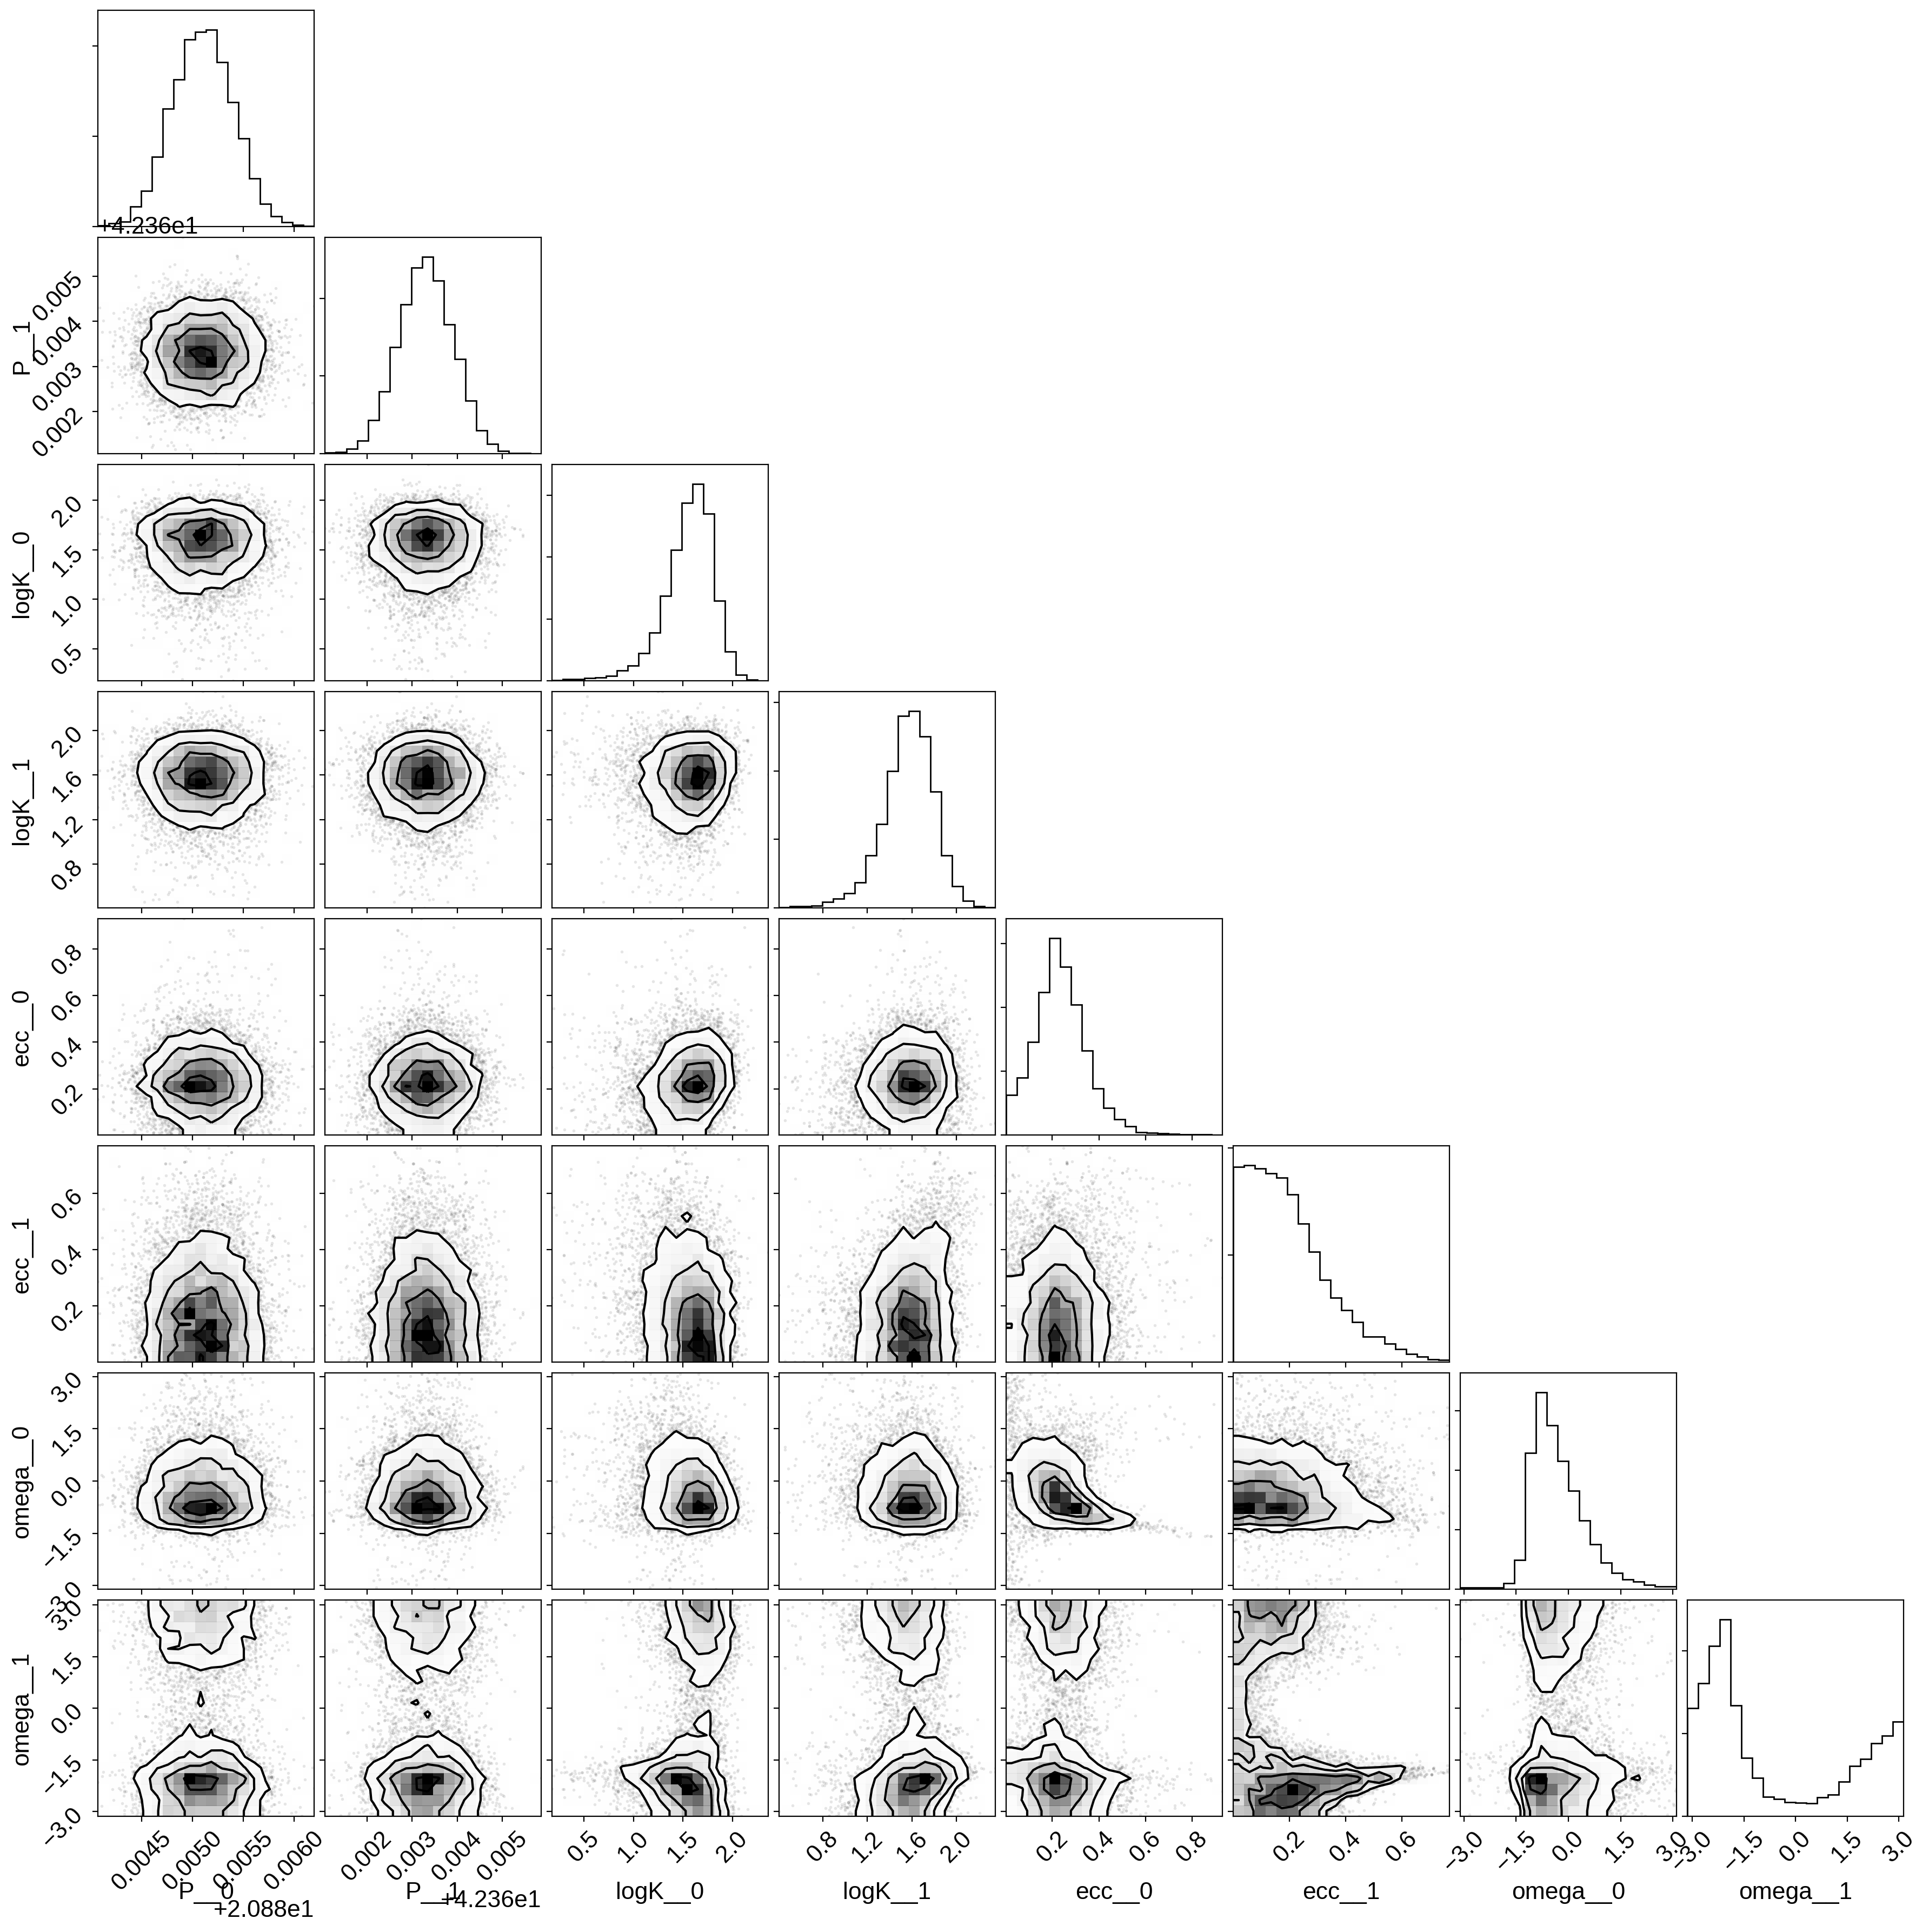

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

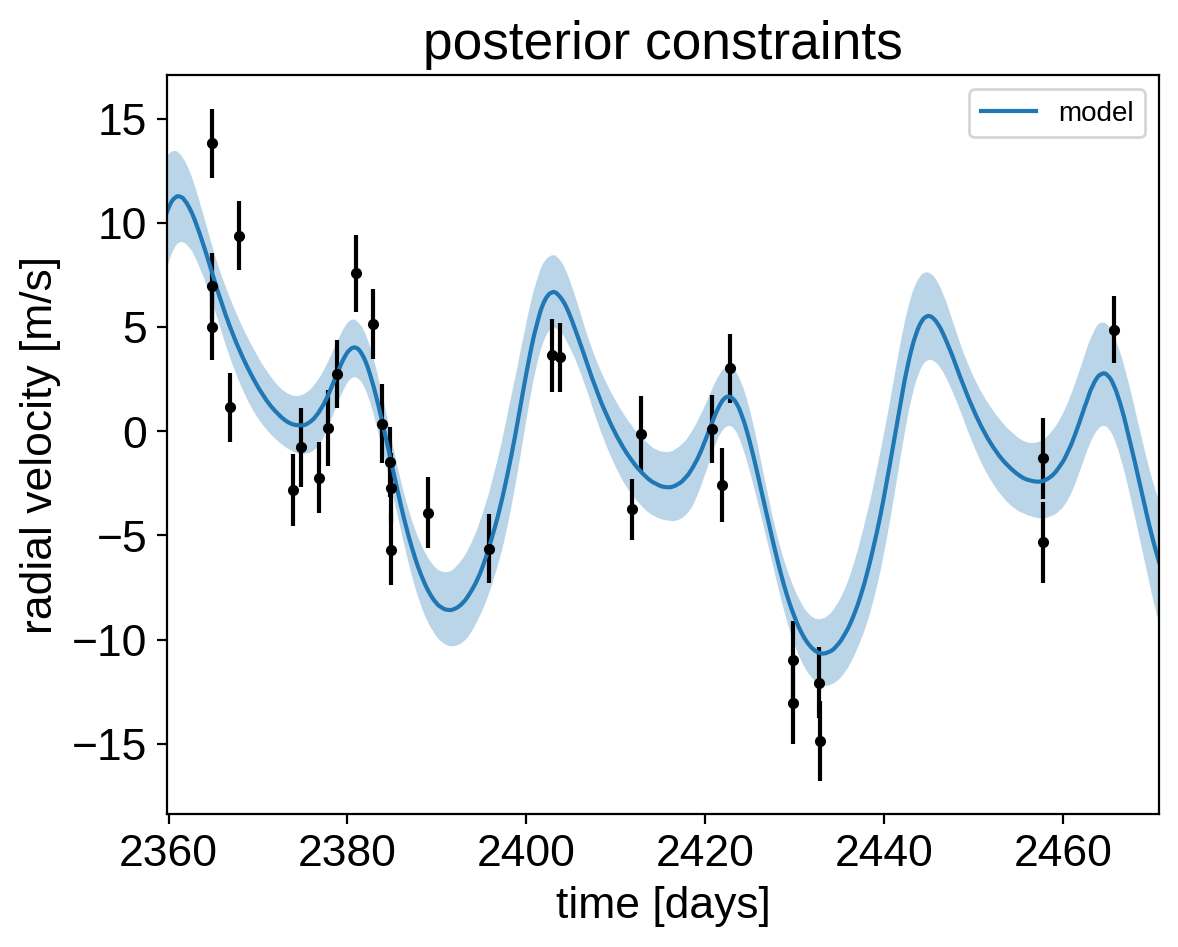

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

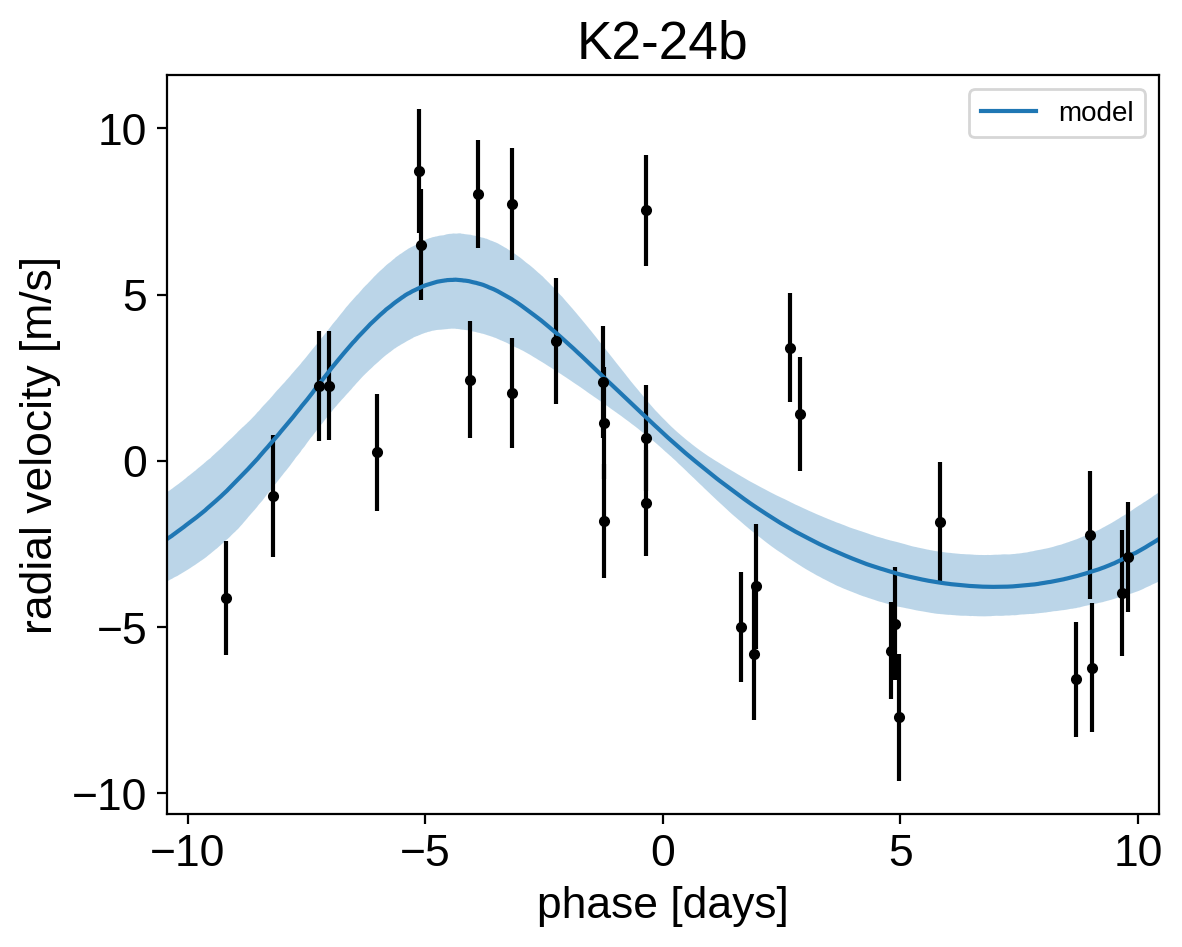

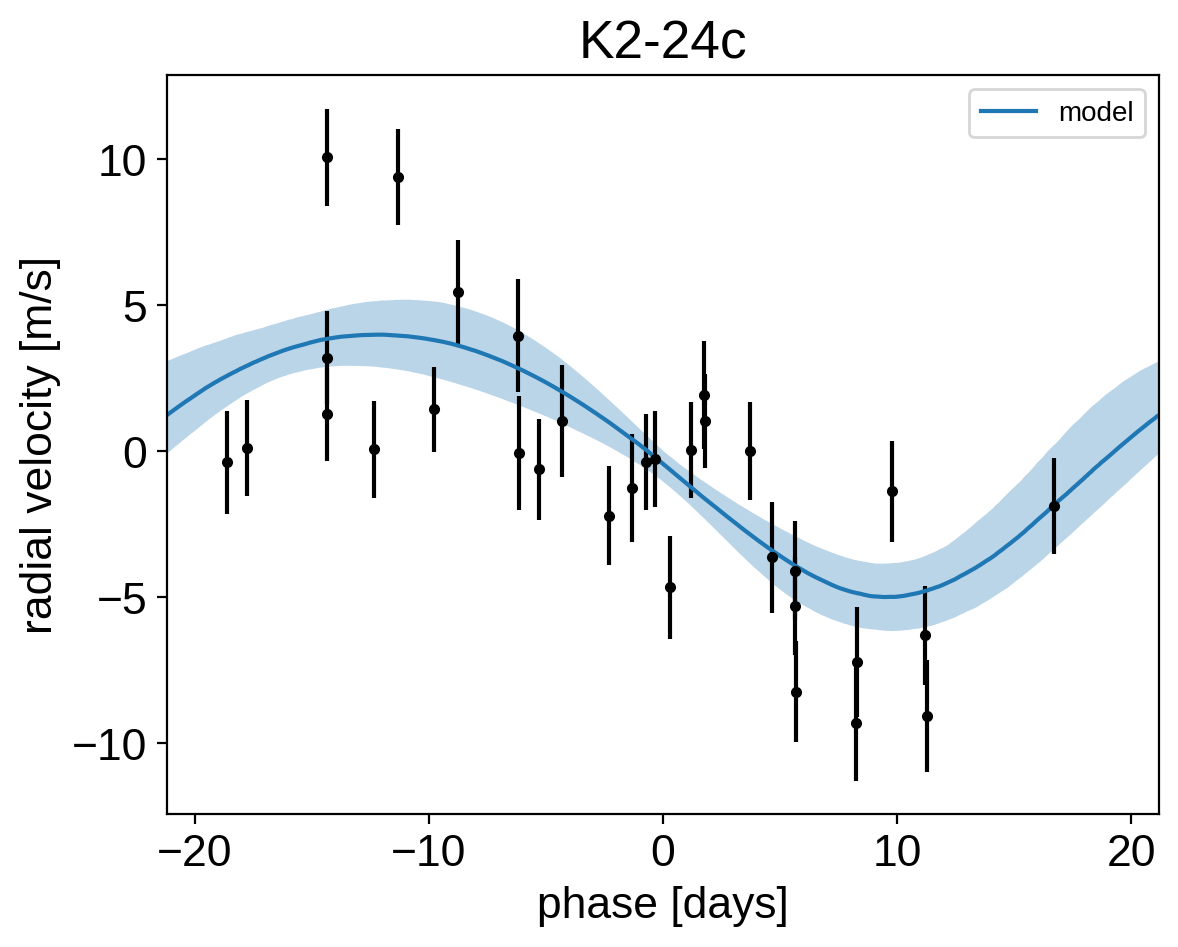

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [15]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
